In [1]:
import glob
import numpy as np
import pandas as pd
import parselmouth 
import statistics
import matplotlib.pyplot as plt

from parselmouth.praat import call
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, power_transform
import sklearn.preprocessing

import tensorflow as tf

import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten

In [2]:
def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    duration = call(sound, "Get total duration") # duration
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    
    #harmonic/spectral
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)

    #pulses
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    #jitter
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    #shimmer
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    #ddpShimmer = call([sound, pointProcess], "Get shimmer (ddp)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    

    return duration, meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, ddaShimmer

import librosa

def mfcc_retrieve(n_mfcc, wavs):

  loads = []

  for i in wavs:
    y, sr = librosa.load(i)
    loads.append([y, sr])

  mfccs = []
  for i in loads:
    mfcc = librosa.feature.mfcc(y=i[0], sr=i[1], n_mfcc=n_mfcc)
    mfccs.append(mfcc)
  
  return(mfccs)

def mfcc_retrieve_delta(n_mfcc, wavs):
  loads = []

  for i in wavs:
    y, sr = librosa.load(i)
    loads.append([y, sr])

  mfccs = []
  for i in loads:
    mfcc = librosa.feature.mfcc(y=i[0], sr=i[1], n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfccs.append(mfcc_delta)
  
  return(mfccs)
  
def mfcc_2delta(n_mfcc, wavs):
  loads = []

  for i in wavs:
    y, sr = librosa.load(i)
    loads.append([y, sr])

  mfccs = []
  for i in loads:
    mfcc = librosa.feature.mfcc(y=i[0], sr=i[1], n_mfcc=n_mfcc)
    mfccs.append(librosa.feature.delta(mfcc, order=2))
  return(mfccs)



In [3]:
# get voice ids from string list
with open('list.txt','r') as f:
    voice_ids = f.read().split('\n')[:-1]

FileNotFoundError: [Errno 2] No such file or directory: 'list.txt'

In [291]:
spectral = pd.read_csv('praat_v.csv')
cog = spectral['cog']
eb_5 = spectral['eb_500']
eb_5 = [i*100 for i in eb_5]
eb_1 = spectral['eb_1000']
eb_1 = [i*100 for i in eb_1]

In [25]:
# get H1-H2 CPP values

path_s = []
for i in range(160):
    cut = voice_ids[i].replace('.wav', '')
    path_s.append(cut + '.normtimeVoice')

In [26]:
def open_normtime(path):
    with open(path, 'r') as file:
        d = file.read().split('\t')[1:]
        clean = []
        for i in d:
            clean.append(i.replace('\n?','').replace('\n', ''))
        cols = int(len(clean)/4)
        final = np.array(clean).reshape(cols, 4)
        H1H2 = []
        CCP = []
        for i in range(2,len(final)):
            H1H2.append(final[i][1])
            CCP.append(final[i][3])

    return(H1H2, CCP)
praat_= [open_normtime(i) for i in path_s]

In [27]:
def ave(l):
    inte1 = []
    inte2 = []
    for i in l[0]:
        inte1.append(float(i))
    for i in l[1]:
        inte2.append(float(i))
    av_H = sum(inte1)/len(inte1)
    av_C = sum(inte2)/len(inte2)
    return(av_H, av_C)

h1h2 = []
ccp = []
for i in praat_:
    h1h2.append(ave(i)[0])
    ccp.append(ave(i)[0])

In [4]:
# get measurements from voice_ids 
data_list = [list(measurePitch(i, 30, 400, "Hertz")) for i in voice_ids]

In [5]:
cols = ["duration", "meanF0", "stdevF0", "hnr", "localJitter", "localabsoluteJitter", "rapJitter", "ppq5Jitter", "ddpJitter", "localShimmer", "localdbShimmer", "apq3Shimmer", "ddaShimmer"]
df = pd.DataFrame(data_list, columns=cols)
# local = 4, local shimmer = 9
# local jitter, use percentage between 0-0.14
ddpJ = [i[4] for i in data_list]
ddpJ = [i*100 for i in ddpJ]
ddaS = [i[9] for i in data_list]
ddaS = [i*100 for i in ddaS]
pitch = [i[1] for i in data_list]
har = [i[3] for i in data_list]

In [17]:
roughness_ = "cape_v_roughness_only.xlsx - Sheet1.csv"
breathiness = "cape_v_breathiness_only.xlsx - Sheet1.csv"
capev = pd.read_csv(breathiness)
ratings = list(capev["Average Values"])
file_name = list(capev['File'])
names = []
out = []
new_vl = []
new_ratings = []
for i in voice_ids:
    new = i.replace('.wav', '')
    new = new[:-1]
    tag = new.replace('_','').replace('ENSS','').replace('i','').replace('a','').replace('enss','')
    if tag in file_name:
        names.append(file_name.index(tag))
        new_ratings.append(ratings[file_name.index(tag)])
        new_vl.append(i)



In [56]:
len(h1h2)

160

In [6]:
def intervalising(value_list, b1, b2, b3):
    lower_p = []
    mid_p = []
    upper_p = []
    classes_p = []
    outliers = []
    one_hot = []
    for i in range(len(value_list)):
        if value_list[i] <= b1:
            lower_p.append(i)
            classes_p.append(0)
            one_hot.append([1, 0, 0])
        elif value_list[i] <= b2:
            mid_p.append(i)
            classes_p.append(1)
            one_hot.append([0, 1, 0])
        elif value_list[i] <= b3:
            upper_p.append(i)
            classes_p.append(3)
            one_hot.append([0, 0, 1])
        else:
            outliers.append(i)
    return(lower_p, mid_p, upper_p, outliers, classes_p, one_hot)


In [31]:
lower, mid, upper, outliers, classes_p, one_hot = intervalising(h1h2, 4, 10, 40)
print(len(lower), len(mid), len(upper), len(outliers))

45 67 48 0


In [39]:
# get paths to be read for mfccs
paths = []
for i in voice_ids[:160]:
    paths.append("C:/Users/xulyr/OneDrive/Desktop/testsamples/" + i)

In [32]:
paths = []
for i in path_s:
    paths.append("C:/Users/xulyr/OneDrive/Desktop/testsamples/" + i)

In [40]:
# paths for mfccs without outliers
outliers.sort()
outliers.reverse()
print(outliers)


jitter_paths = [path for path in paths]
for i in outliers:
    jitter_paths.pop(i)
len(jitter_paths)
jitter_paths

[]


['C:/Users/xulyr/OneDrive/Desktop/testsamples/BL01_ENSS_a.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL01_ENSS_i.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL02_ENSS_a.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL02_ENSS_i.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL03_ENSS_a.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL03_ENSS_i.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL04_ENSS_a.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL04_ENSS_i.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL05_ENSS_a.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL05_ENSS_i.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL06_ENSS_a.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL06_ENSS_i.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL07_ENSS_a.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL07_ENSS_i.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsamples/BL08_ENSS_a.wav',
 'C:/Users/xulyr/OneDrive/Desktop/testsa

In [87]:
mfccs_n = 100
mfccs_j = mfcc_retrieve(mfccs_n, jitter_paths)
minlen = min([np.shape(i)[1] for i in mfccs_j])
# each sample has 12 lists of n number of time frames

truncated = []
for i in mfccs_j:
  trunc = [i[n][:minlen] for n in range(len(i))]
  truncated.append(trunc)
np.array(truncated).shape

(160, 100, 74)

In [36]:
mfccs_n =  30
mfccs = mfcc_retrieve(mfccs_n, paths)
minlen = min([np.shape(i)[1] for i in mfccs])
# each sample has 12 lists of n number of time frames

truncated = []
for i in mfccs:
  trunc = [i[n][:minlen] for n in range(len(i))]
  truncated.append(trunc)
np.array(truncated).shape

C:\Users\xulyr\AppData\Local\Temp\ipykernel_30084\1415787450.py:39: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(i)
c:\Users\xulyr\anaconda3\envs\librosa\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


NoBackendError: 

In [88]:
# only run once
import random
ind = list(range(len(one_hot)))
random.shuffle(ind)

In [251]:
len(one_hot)

296

In [89]:
# truncated mfccs as X
# classes as Y 

# training/test set preperation

split = 90

shuffled_mfccs = []
shuffled_labels = []
for i in ind:
  shuffled_mfccs.append(truncated[i])
  shuffled_labels.append(one_hot[i])

trainx = np.array(shuffled_mfccs[:split])
trainY = np.array(shuffled_labels[:split])

testx = np.array(shuffled_mfccs[split:])
testY = np.array(shuffled_labels[split:])

trainx = trainx.reshape(split, mfccs_n, minlen, 1)
testx = testx.reshape(len(shuffled_mfccs) - split, mfccs_n, minlen, 1)

In [90]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(mfccs_n, minlen, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(mfccs_n, minlen, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 98, 72, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 49, 36, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 49, 36, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 47, 34, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 23, 17, 32)       0         
 g2D)                                                            
                                                      

In [91]:
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [92]:
history = model.fit(trainx, trainY, validation_data=(testx, testY), epochs=25, batch_size=32, verbose=2)

Epoch 1/25
3/3 - 1s - loss: 8.8605 - accuracy: 0.3444 - val_loss: 17.8422 - val_accuracy: 0.2571 - 1s/epoch - 412ms/step
Epoch 2/25
3/3 - 0s - loss: 7.0873 - accuracy: 0.4333 - val_loss: 11.9503 - val_accuracy: 0.2571 - 312ms/epoch - 104ms/step
Epoch 3/25
3/3 - 0s - loss: 6.8422 - accuracy: 0.4333 - val_loss: 7.4564 - val_accuracy: 0.3286 - 303ms/epoch - 101ms/step
Epoch 4/25
3/3 - 0s - loss: 2.6638 - accuracy: 0.5111 - val_loss: 4.2989 - val_accuracy: 0.3571 - 299ms/epoch - 100ms/step
Epoch 5/25
3/3 - 0s - loss: 2.6069 - accuracy: 0.6333 - val_loss: 3.6392 - val_accuracy: 0.4000 - 292ms/epoch - 97ms/step
Epoch 6/25
3/3 - 0s - loss: 0.9738 - accuracy: 0.7889 - val_loss: 2.5145 - val_accuracy: 0.4143 - 304ms/epoch - 101ms/step
Epoch 7/25
3/3 - 0s - loss: 0.7325 - accuracy: 0.7667 - val_loss: 4.0676 - val_accuracy: 0.3714 - 302ms/epoch - 101ms/step
Epoch 8/25
3/3 - 0s - loss: 0.2432 - accuracy: 0.9556 - val_loss: 2.3580 - val_accuracy: 0.4286 - 311ms/epoch - 104ms/step
Epoch 9/25
3/3 - 0

In [644]:
# 4 mfccs: 0.4917, 0.4795
# 9 mfccs loss: 2.6158 - accuracy: 0.4833 - val_loss: 3.4197 - val_accuracy: 0.3973 - 68ms/epoch - 17ms/step
# 12 mfccs 4/4 - 0s - loss: 2.7666 - accuracy: 0.5250 - val_loss: 5.3478 - val_accuracy: 0.3288 - 81ms/epoch - 20ms/step
# 19 mfccs 4/4 - 0s - loss: 1.1627 - accuracy: 0.8167 - val_loss: 6.3359 - val_accuracy: 0.3699 - 106ms/epoch - 27ms/step
# 26 mfccs 4/4 - 0s - loss: 0.7890 - accuracy: 0.7917 - val_loss: 4.1593 - val_accuracy: 0.4521 - 130ms/epoch - 32ms/step
# 33 mfccs 4/4 - 0s - loss: 0.7445 - accuracy: 0.8333 - val_loss: 5.2101 - val_accuracy: 0.5068 - 146ms/epoch - 36ms/step
# 40 4/4 - 0s - loss: 0.1778 - accuracy: 0.9500 - val_loss: 11.4494 - val_accuracy: 0.3836 - 162ms/epoch - 40ms/step
# 47 4/4 - 0s - loss: 0.0944 - accuracy: 0.9667 - val_loss: 13.5724 - val_accuracy: 0.3151 - 189ms/epoch - 47ms/step
# 54 4/4 - 0s - loss: 3.0817 - accuracy: 0.6833 - val_loss: 30.3871 - val_accuracy: 0.3699 - 212ms/epoch - 53ms/step
# 61 4/4 - 0s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.5256 - val_accuracy: 0.4194 - 301ms/epoch - 75ms/step
# 70 4/4 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 3.7473 - val_accuracy: 0.4624 - 351ms/epoch - 88ms/step
# 80 4/4 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 7.2986 - val_accuracy: 0.3441 - 388ms/epoch - 97ms/step
# 100 4/4 - 0s - loss: 2.7976e-04 - accuracy: 1.0000 - val_loss: 6.8111 - val_accuracy: 0.4624 - 487ms/epoch - 122ms/step
# 120

# 10 5/5 - 0s - loss: 0.1344 - accuracy: 1.0000 - val_loss: 1.1277 - val_accuracy: 0.3492
# 12 5/5 - 0s - loss: 0.1535 - accuracy: 0.9923 - val_loss: 1.3071 - val_accuracy: 0.3651
# 19 5/5 - 0s - loss: 0.0601 - accuracy: 1.0000 - val_loss: 1.0319 - val_accuracy: 0.4762 - 104ms/epoch - 21ms/step
# 26 5/5 - 0s - loss: 0.0272 - accuracy: 1.0000 - val_loss: 1.1417 - val_accuracy: 0.4286
# 33 5/5 - 0s - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.1398 - val_accuracy: 0.4444
#40 5/5 - 0s - loss: 0.0078 - accuracy: 1.0000 - val_loss: 1.8001 - val_accuracy: 0.4444
# 47 5/5 - 0s - loss: 0.0141 - accuracy: 1.0000 - val_loss: 1.1002 - val_accuracy: 0.4127
# 54 5/5 - 0s - loss: 0.0133 - accuracy: 1.0000 - val_loss: 1.0364 - val_accuracy: 0.4444
# 61 5/5 - 0s - loss: 0.0101 - accuracy: 1.0000 - val_loss: 1.8677 - val_accuracy: 0.4127
# 70 5/5 - 0s - loss: 0.0081 - accuracy: 1.0000 - val_loss: 1.5441 - val_accuracy: 0.4286
# 80 5/5 - 0s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.4260 - val_accuracy: 0.3810
# 100 5/5 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.2223 - val_accuracy: 0.3810 


#10 5/5 - 0s - loss: 0.0993 - accuracy: 1.0000 - val_loss: 1.1908 - val_accuracy: 0.3333 - 97ms/epoch - 19ms/ste
# 20 5/5 - 0s - loss: 0.0542 - accuracy: 1.0000 - val_loss: 1.0731 - val_accuracy: 0.4286 - 137ms/epoch - 27ms/step
# 30 5/5 - 0s - loss: 0.0256 - accuracy: 1.0000 - val_loss: 1.3212 - val_accuracy: 0.3651 - 167ms/epoch - 33ms/step
# 40 5/5 - 0s - loss: 0.0171 - accuracy: 1.0000 - val_loss: 1.2106 - val_accuracy: 0.3968 - 173ms/epoch - 35ms/step
# 50 5/5 - 0s - loss: 0.0151 - accuracy: 1.0000 - val_loss: 1.6243 - val_accuracy: 0.3492 - 213ms/epoch - 43ms/step
# 60 5/5 - 0s - loss: 0.0159 - accuracy: 1.0000 - val_loss: 1.1026 - val_accuracy: 0.4762 - 240ms/epoch - 48ms/step
# 70 /5 - 0s - loss: 0.0107 - accuracy: 1.0000 - val_loss: 1.2730 - val_accuracy: 0.4762 - 230ms/epoch - 46ms/step
# 80 5/5 - 0s - loss: 0.0081 - accuracy: 1.0000 - val_loss: 2.0617 - val_accuracy: 0.3651 - 310ms/epoch - 62ms/step
# 90 5/5 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.8786 - val_accuracy: 0.3651 - 339ms/epoch - 68ms/step
# 100 5/5 - 0s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.4535 - val_accuracy: 0.3651 - 351ms/epoch - 70ms/step

0.5522, 0.4925, 0.4030, 0.5224, 0.4179, 0.4925, 0.5821, 0.4328, 0.3134, 0.4478
0.3284, 0.4328, 0.5224, 0.4627, 0.4925, 0.3731
0.3433, 0.3433, 0.4030, 0.4179, 0.4776, 0.3582

0.3944, 0.4085, 0.4648, 0.5211, 0.5070, 0.4930, 0.4225, 0.4789, 0.4789, 0.3803
0.3099, 0.3944, 0.3662, 0.3099, 0.2676, 0.4321
0.2963, 0.4321, 0.4568, 0.3827, 0.3827, 0.2840

[0.4048, 0.4048, 0.5476, 0.4524, 0.5476, 0.5238, 0.5238, 0.5238, 0.6905, 0.6190]
[0.3810, 0.3095, 0.3333, 0.2619, 0.2381, 0.2381, 0.3333, 0.4762, 0.5000, 0.4762]
[0.3571, 0.4048, 0.2857, 0.2857, 0.4762, 0.3571, 0.3810, 0.3095, 0.3571, 0.5644]

# cog
[0.5556, 0.6481, 0.6852, 0.7222, 0.5741, 0.5556, 0.5185, 0.6296, 0.5556, 0.6481]
[0.4444, 0.4074, 0.4074, 0.3519,  0.5556, 0.3333, 0.5000, 0.3889, 0.5370, 0.4074]
[0.4815, 0.4630, 0.4444, 0.4074, 0.4630,  0.3704, 0.3704, 0.5556, 0.3148, 0.3148]

# eb 500
[0.5217, 0.4130, 0.5000, 0.6739, 0.5870, 0.4783, 0.4783, 0.5217, 0.4783, 0.4348]
[0.3043, 0.3043, 0.2609,0.4565, 0.4565, 0.3261, 0.3478, 0.3261, 0.3478, 0.3261]
[0.4348, 0.3478, 0.3043,  0.3913, 0.3696, 0.4348, 0.4783, 0.4130, 0.3913, 0.3913]

[0.3667, 0.4833, 0.5667, 0.5667, 0.5667, 0.5167, 0.5333, 0.5833, 0.4833, 0.5500]
[0.4500, 0.3000, 0.3167, 0.3667, 0.3500, 0.4000, 0.3667, 0.3167, 0.3333, 0.4000]
[0.2667, 0.3000, 0.2167, 0.2167, 0.2333, 0.4000, 0.3833, 0.3667, 0.3667, 0.3500]

0.5216700000000001


<function matplotlib.pyplot.show(close=None, block=None)>

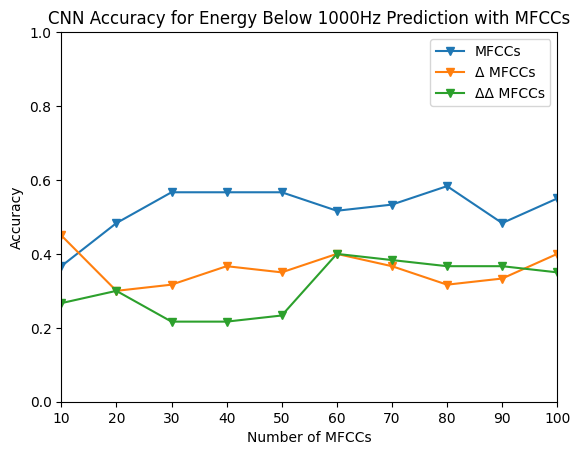

In [102]:
num_m = list(range(10, 110, 10))

val_accs = [0.3667, 0.4833, 0.5667, 0.5667, 0.5667, 0.5167, 0.5333, 0.5833, 0.4833, 0.5500]

print(sum(val_accs)/10)

val_accs_delta = [0.4500, 0.3000, 0.3167, 0.3667, 0.3500, 0.4000, 0.3667, 0.3167, 0.3333, 0.4000]
num_m2delta = list(range(10, 110, 10))
val_2detla = [0.2667, 0.3000, 0.2167, 0.2167, 0.2333, 0.4000, 0.3833, 0.3667, 0.3667, 0.3500]
og = plt.plot(num_m, val_accs, marker = 'v')
delt = plt.plot(num_m, val_accs_delta, marker = 'v')
delt2 = plt.plot(num_m, val_2detla, marker = 'v')
#plt.plot(num_m, train_accs)
plt.axis([10, 100, 0, 1])
plt.xlabel('Number of MFCCs')
plt.ylabel('Accuracy')
plt.legend(['MFCCs', u'Δ MFCCs', u'ΔΔ MFCCs'])
plt.title('CNN Accuracy for Energy Below 1000Hz Prediction with MFCCs')
plt.show

0.52073


<function matplotlib.pyplot.show(close=None, block=None)>

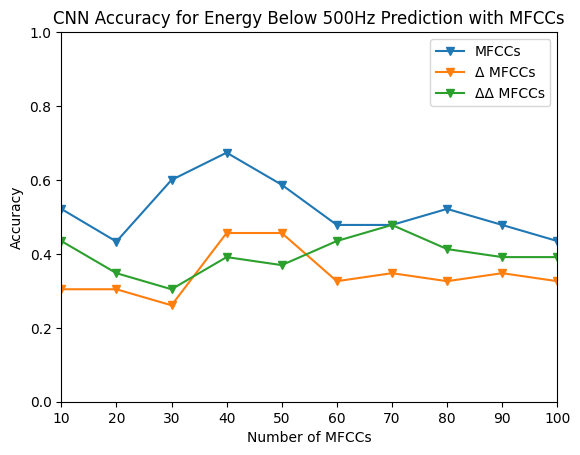

In [101]:
num_m = list(range(10, 110, 10))

val_accs = [0.5217, 0.4333, 0.6000, 0.6739, 0.5870, 0.4783, 0.4783, 0.5217, 0.4783, 0.4348]

print(sum(val_accs)/10)

val_accs_delta = [0.3043, 0.3043, 0.2609,0.4565, 0.4565, 0.3261, 0.3478, 0.3261, 0.3478, 0.3261]
num_m2delta = list(range(10, 110, 10))
val_2detla = [0.4348, 0.3478, 0.3043,  0.3913, 0.3696, 0.4348, 0.4783, 0.4130, 0.3913, 0.3913]
og = plt.plot(num_m, val_accs, marker = 'v')
delt = plt.plot(num_m, val_accs_delta, marker = 'v')
delt2 = plt.plot(num_m, val_2detla, marker = 'v')
#plt.plot(num_m, train_accs)
plt.axis([10, 100, 0, 1])
plt.xlabel('Number of MFCCs')
plt.ylabel('Accuracy')
plt.legend(['MFCCs', u'Δ MFCCs', u'ΔΔ MFCCs'])
plt.title('CNN Accuracy for Energy Below 500Hz Prediction with MFCCs')
plt.show

0.60926


<function matplotlib.pyplot.show(close=None, block=None)>

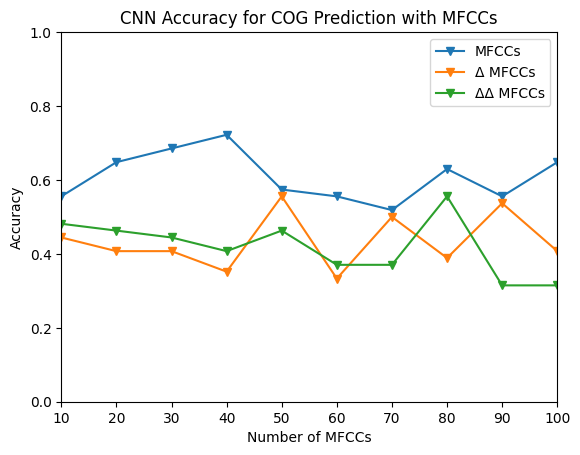

In [100]:
num_m = list(range(10, 110, 10))

val_accs = [0.5556, 0.6481, 0.6852, 0.7222, 0.5741, 0.5556, 0.5185, 0.6296, 0.5556, 0.6481]

print(sum(val_accs)/10)

val_accs_delta = [0.4444, 0.4074, 0.4074, 0.3519,  0.5556, 0.3333, 0.5000, 0.3889, 0.5370, 0.4074]
num_m2delta = list(range(10, 110, 10))
val_2detla = [0.4815, 0.4630, 0.4444, 0.4074, 0.4630,  0.3704, 0.3704, 0.5556, 0.3148, 0.3148]
og = plt.plot(num_m, val_accs, marker = 'v')
delt = plt.plot(num_m, val_accs_delta, marker = 'v')
delt2 = plt.plot(num_m, val_2detla, marker = 'v')
#plt.plot(num_m, train_accs)
plt.axis([10, 100, 0, 1])
plt.xlabel('Number of MFCCs')
plt.ylabel('Accuracy')
plt.legend(['MFCCs', u'Δ MFCCs', u'ΔΔ MFCCs'])
plt.title('CNN Accuracy for COG Prediction with MFCCs')
plt.show

0.52381


<function matplotlib.pyplot.show(close=None, block=None)>

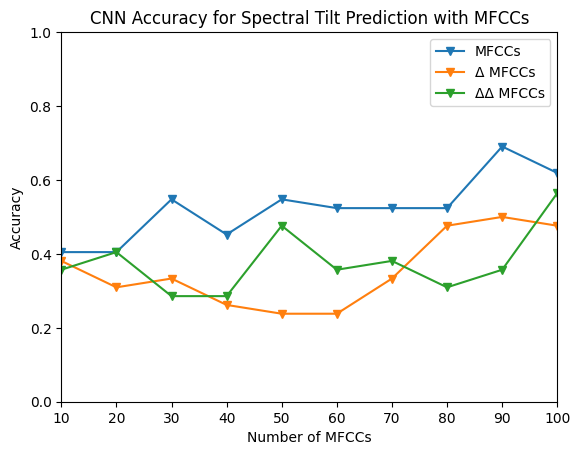

In [96]:

num_m = list(range(10, 110, 10))

val_accs = [0.4048, 0.4048, 0.5476, 0.4524, 0.5476, 0.5238, 0.5238, 0.5238, 0.6905, 0.6190]

print(sum(val_accs)/10)

val_accs_delta = [0.3810, 0.3095, 0.3333, 0.2619, 0.2381, 0.2381, 0.3333, 0.4762, 0.5000, 0.4762]
num_m2delta = list(range(10, 110, 10))
val_2detla = [0.3571, 0.4048, 0.2857, 0.2857, 0.4762, 0.3571, 0.3810, 0.3095, 0.3571, 0.5644]
og = plt.plot(num_m, val_accs, marker = 'v')
delt = plt.plot(num_m, val_accs_delta, marker = 'v')
delt2 = plt.plot(num_m, val_2detla, marker = 'v')
#plt.plot(num_m, train_accs)
plt.axis([10, 100, 0, 1])
plt.xlabel('Number of MFCCs')
plt.ylabel('Accuracy')
plt.legend(['MFCCs', u'Δ MFCCs', u'ΔΔ MFCCs'])
plt.title('CNN Accuracy for Spectral Tilt Prediction with MFCCs')
plt.show

0.39624000000000004


<function matplotlib.pyplot.show(close=None, block=None)>

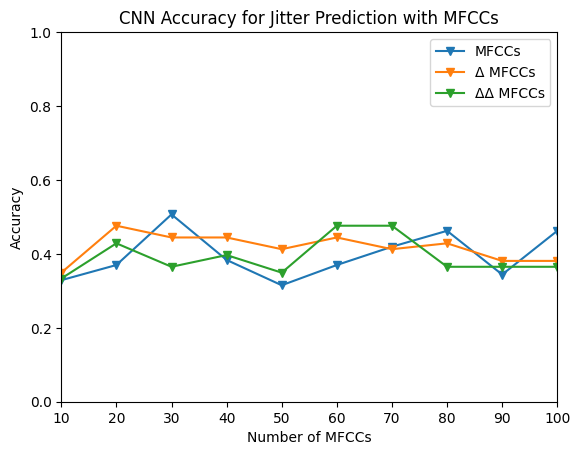

In [97]:
#num_m = [4, 9, 12, 19, 26, 33, 40, 47, 54, 61, 70, 80, 100]
num_m = list(range(10, 110, 10))
#val_accs = [0.4795, 0.3973, 0.3288, 0.3699, 0.4521, 0.5068,  0.3836, 0.3151, 0.3699, 0.4194, 0.4624, 0.3441, 0.4624]
val_accs = [0.3288, 0.3699, 0.5068,  0.3836, 0.3151, 0.3699, 0.4194, 0.4624, 0.3441, 0.4624]
print(sum(val_accs)/10)
#train_accs = [0.4917, 0.4833, 0.5250, 0.8167, 0.7917, 0.8333, 0.9500, 0.9667, 0.6833]
num_m_delta = [10, 12, 19, 26, 33, 40, 47, 54, 61, 70, 80, 100]
val_accs_delta = [0.3492, 0.3651, 0.4762, 0.4286, 0.4444, 0.4444, 0.4127, 0.4444, 0.4127, 0.4286, 0.3810, 0.3810]
val_accs_delta = [0.3492, 0.4762, 0.4444, 0.4444, 0.4127, 0.4444, 0.4127, 0.4286, 0.3810, 0.3810]
num_m2delta = list(range(10, 110, 10))
val_2detla = [0.3333, 0.4286, 0.3651, 0.3968, 0.3492, 0.4762, 0.4762, 0.3651, 0.3651, 0.3651]
og = plt.plot(num_m, val_accs, marker = 'v')
delt = plt.plot(num_m, val_accs_delta, marker = 'v')
delt2 = plt.plot(num_m, val_2detla, marker = 'v')
#plt.plot(num_m, train_accs)
plt.axis([10, 100, 0, 1])
plt.xlabel('Number of MFCCs')
plt.ylabel('Accuracy')
plt.legend(['MFCCs', u'Δ MFCCs', u'ΔΔ MFCCs'])
plt.title('CNN Accuracy for Jitter Prediction with MFCCs')
plt.show

0.46566


<function matplotlib.pyplot.show(close=None, block=None)>

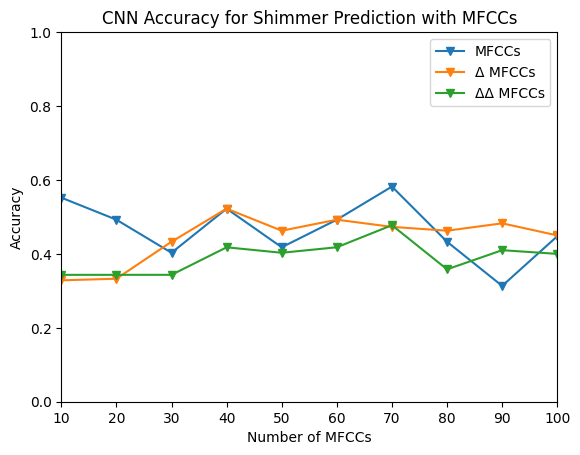

In [98]:
num_m = list((range(10, 110, 10)))
val_accs = [0.5522, 0.4925, 0.4030, 0.5224, 0.4179, 0.4925, 0.5821, 0.4328, 0.3134, 0.4478]
print(sum(val_accs)/10)
num_m_delta = [10, 30, 50, 70, 90, 100]
val_accs_delta = [0.3284, 0.3328, 0.4328, 0.5224, 0.4627, 0.4925, 0.4731, 0.4627, 0.4827, 0.4500]
#val_accs_delta = [0.3284, ]
num_m2delta = [10, 30, 50, 70, 90, 100]
val_2detla = [0.3433, 0.3433, 0.3433, 0.4178, 0.4030, 0.4179, 0.4776, 0.3582, 0.41, 0.4]
og = plt.plot(num_m, val_accs, marker = 'v')
delt = plt.plot(num_m, val_accs_delta, marker = 'v')
delt2 = plt.plot(num_m, val_2detla, marker = 'v')
#plt.plot(num_m, train_accs)
plt.axis([10, 100, 0, 1])
plt.xlabel('Number of MFCCs')
plt.ylabel('Accuracy')
plt.legend(['MFCCs', u'Δ MFCCs', u'ΔΔ MFCCs'])
plt.title('CNN Accuracy for Shimmer Prediction with MFCCs')
plt.show

0.45494


<function matplotlib.pyplot.show(close=None, block=None)>

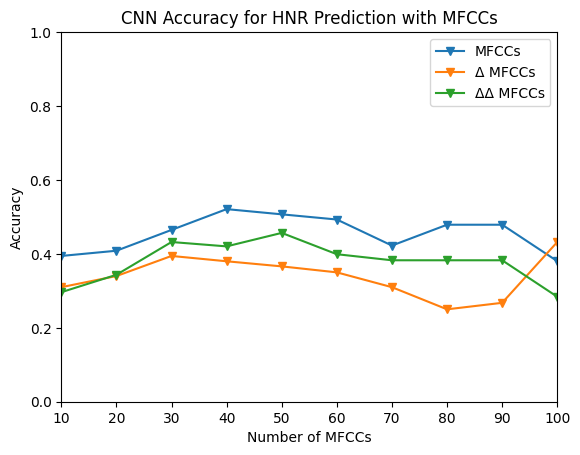

In [99]:
num_m = list((range(10, 110, 10)))
val_accs = [0.3944, 0.4085, 0.4648, 0.5211, 0.5070, 0.4930, 0.4225, 0.4789, 0.4789, 0.3803]
print(sum(val_accs)/10)
num_m_delta = [10, 30, 50, 70, 90, 100]

val_accs_delta = [0.3099, 0.3944, 0.3662, 0.3099, 0.2676, 0.4321]
val_accs_delta = [0.3099, 0.34, 0.3944, 0.38, 0.3662, 0.35, 0.3099, 0.25, 0.2676, 0.4321]

num_m2delta = [10, 30, 50, 70, 90, 100]
val_2detla = [0.2963, 0.4321, 0.4568, 0.3827, 0.3827, 0.2840]
val_2detla = [0.2963, 0.3434, 0.4321, 0.4203, 0.4568, 0.3991, 0.3827, 0.3827, 0.3827, 0.2840]
og = plt.plot(num_m, val_accs, marker='v')
delt = plt.plot(num_m, val_accs_delta, marker = 'v')
delt2 = plt.plot(num_m, val_2detla, marker = 'v')
#plt.plot(num_m, train_accs)
plt.axis([10, 100, 0, 1])
plt.xlabel('Number of MFCCs')
plt.ylabel('Accuracy')
plt.legend(['MFCCs', u'Δ MFCCs', u'ΔΔ MFCCs'])
plt.title('CNN Accuracy for HNR Prediction with MFCCs')
plt.show

In [93]:
prediction = model.predict(np.array(testx))

3/3 [==============================] - 0s 22ms/step


In [94]:
low_pred = []
mid_pred = []
high_pred = []

for i in range(len(testY)):
    if (testY[i] == [1,0,0]).all():
        low_pred.append(prediction[i])
    elif (testY[i] == [0,1,0]).all():
        mid_pred.append(prediction[i])
    elif (testY[i] == [0,0,1]).all():
        high_pred.append(prediction[i])

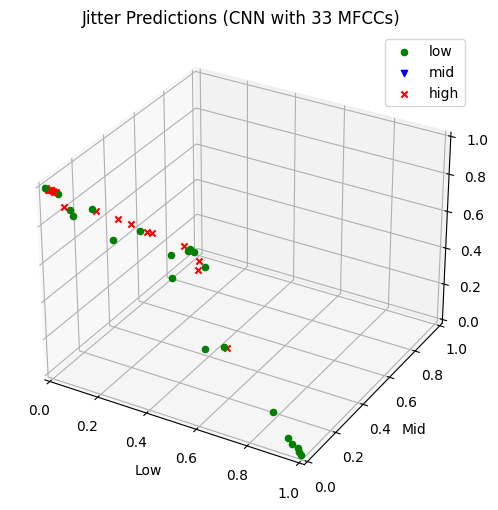

In [95]:
#from mpl_toolkits import mplot3d

 
# Creating figure
fig = plt.figure(figsize = (50, 6))
ax = plt.axes(projection ="3d")
 
# Creating plot
for i in low_pred:
    l = ax.scatter3D(i[0], i[1], i[2], color = "green", label = "low")
#for i in mid_pred:
    #m = ax.scatter3D(i[0], i[1], i[2], color = "blue", marker = "v", label = "mid")
for i in high_pred:
    h = ax.scatter3D(i[0], i[1], i[2], color = "red", marker = "x", label = "high")

plt.title(u"Jitter Predictions (CNN with 33 MFCCs)")
ax.set_xlabel('Low')
ax.set_ylabel('Mid')
ax.axes.set_xlim3d(left=0, right=1) 
ax.axes.set_ylim3d(bottom=0, top=1) 
ax.axes.set_zlim3d(bottom=0, top=1) 
#ax.set_zlabel('High')
ax.legend(handles=[l, m, h])

plt.show()

In [ ]:
#SVM data prep--> input features must be 1d list for each sample 
# 

In [809]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(trainx, trainY)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

ValueError: Found array with dim 4. SVC expected <= 2.

[ 0  0  1  9 13 22 19 17 21 15 14  4  7  7  5  2  3  1  7  4  1  0  3  2
  1  2  2  2  3  0  1  0  1  0  1  1  1  0  1  0]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195]


<function matplotlib.pyplot.show(close=None, block=None)>

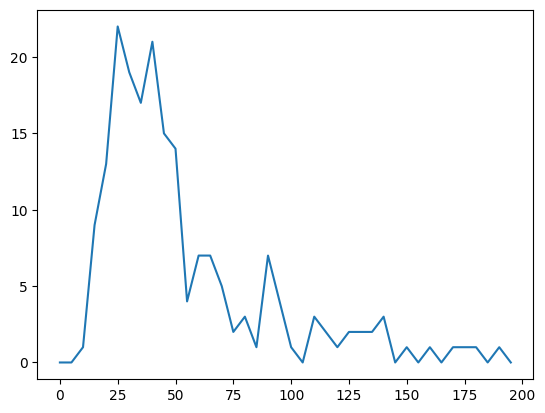

In [93]:

x = np.array(ddpJ).reshape(-1, 1)

x_norm = sklearn.preprocessing.MinMaxScaler().fit_transform(x)
frequency, bins = np.histogram(x, bins=40, range=[0, 2]) #0-0.20, 0.20-0.4, >0.4
#plt.plot(frequency, bins)
#plt.show
print(frequency)
print(list(range(0, 200, 5)))
plt.plot( list(range(0, 200, 5)), frequency)
plt.show

In [63]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=7, random_state=5)
clustering.fit(np.array(ddpJ).reshape(-1, 1))
clustering.labels_

c:\Users\xulyr\anaconda3\envs\librosa\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 2, 5, 3, 3, 0, 0, 5, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 5, 0, 0, 0, 0, 0, 3, 5, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0,
       0, 0, 5, 0, 6, 2, 0, 0, 5, 0, 5, 0, 6, 5, 5, 2, 0, 0, 0, 0, 2, 3,
       5, 0, 0, 3, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       5, 3, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0, 5, 3, 5, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 5, 3, 5,
       3, 0, 5, 5, 5, 0, 2, 5, 0, 0, 2, 5, 5, 3, 0, 0, 0, 0, 1, 5, 0, 3,
       3, 0, 4, 0, 6, 3, 2, 3, 5, 0, 0, 0, 3, 0, 0, 5, 5, 0, 0, 0, 3, 5,
       5, 0, 0, 0])